In [20]:
import numpy as np
import heapq
import torch
import torch.nn as nn
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

class VectorNet(nn.Module):
    def __init__(
        self,
    ) -> None:
        super(VectorNet, self).__init__()
        # 64 -> 55
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=5, kernel_size=10, padding="valid")
        self.a1 = nn.PReLU()
        # 55 -> 51
        self.conv2 = nn.Conv1d(in_channels=5, out_channels=5, kernel_size=5, padding="valid")
        self.a2 = nn.PReLU()
        self.fc1 = nn.Linear(5 * 51, 32)
        self.a3 = nn.PReLU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.a1(x)
        x = self.conv2(x)
        x = self.a2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.a3(x)
        return x


class CompareNet(nn.Module):
    def __init__(self):
        super(CompareNet, self).__init__()
        # 32 -> 23
        self.conv1 = nn.Conv1d(in_channels=2, out_channels=4, kernel_size=10, padding="valid")
        self.a1 = nn.PReLU()
        # 23 -> 19
        self.conv2 = nn.Conv1d(in_channels=4, out_channels=2, kernel_size=5, padding="valid")
        self.a2 = nn.PReLU()
        self.fc1 = nn.Linear(2 * 19, 1)
        self.a3 = nn.Sigmoid()

    def forward(self, x):
        x = self.conv1(x)
        x = self.a1(x)
        x = self.conv2(x)
        x = self.a2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.a3(x)
        return x

f_model = VectorNet()
c_model = CompareNet()

f_model.load_state_dict(torch.load('models/f_model.pth'))
c_model.load_state_dict(torch.load('models/c_model.pth'))

def inference(f_model, c_model, vector_1, vector_2):
    '''Description: This function is used to calculate the distance between two vectors'''
    f_model.eval()
    c_model.eval()
    feature_1 = f_model(vector_1)
    feature_2 = f_model(vector_2)
    dis = c_model(torch.stack((feature_1, feature_2), 1))
    return dis

In [21]:
# Fast Matching Method
def fast_marching_distance(v1, v2):
    # Ensure the input vectors are numpy arrays
    v1 = np.asarray(v1)
    v2 = np.asarray(v2)
    
    # Check if the vectors have the same length
    assert v1.shape == v2.shape, "Vectors must be of the same shape"
    
    # Initialize the distance and known arrays
    distance = np.full(v1.shape, np.inf)
    known = np.zeros(v1.shape, dtype=bool)
    
    # Priority queue to store the distances
    heap = []

    # Initialize with the first element (or any specific start point)
    heapq.heappush(heap, (0, 0))
    distance[0] = 0
    known[0] = True

    # Define neighbors (for 1D, it's just the previous and next indices)
    neighbors = lambda idx: [idx - 1, idx + 1]

    while heap:
        dist, idx = heapq.heappop(heap)
        for n in neighbors(idx):
            if 0 <= n < len(v1) and not known[n]:
                new_dist = dist + abs(v1[n] - v2[n])
                if new_dist < distance[n]:
                    distance[n] = new_dist
                    heapq.heappush(heap, (new_dist, n))
                    known[n] = True

    # The final score is the total accumulated distance
    total_distance = np.sum(distance)
    return total_distance

In [22]:
# Dynamic Time Warping (DTW)
def dynamic_time_warping(v1, v2):
    n, m = len(v1), len(v2)
    dtw_matrix = np.zeros((n+1, m+1))

    # Initialize the distance matrix with infinity
    dtw_matrix[1:, 0] = np.inf
    dtw_matrix[0, 1:] = np.inf

    # Set the first element to 0
    dtw_matrix[0, 0] = 0

    # Fill the DTW matrix
    for i in range(1, n+1):
        for j in range(1, m+1):
            cost = abs(v1[i-1] - v2[j-1])
            # Take the minimum of the three possible transitions
            dtw_matrix[i, j] = cost + min(dtw_matrix[i-1, j],    # Insertion
                                          dtw_matrix[i, j-1],    # Deletion
                                          dtw_matrix[i-1, j-1])  # Match

    # The DTW distance is found at the bottom-right of the matrix
    dtw_distance = dtw_matrix[n, m]
    return dtw_distance

In [23]:
# cosine similarity
def cosine_similarity(v1, v2):
    # calculating the dot product of the two vectors
    dot_product = np.dot(v1, v2)
    # calculating the norm of each vector
    norm_v1 = np.linalg.norm(v1)
    norm_v2 = np.linalg.norm(v2)
    # calculating cosine similarity
    cosine_sim = dot_product / (norm_v1 * norm_v2)
    return cosine_sim

In [24]:
# Scale Invariant Signature (SIS)
def compute_curvature(v):
    """calculate the curvature of a 1D curve"""
    dv = np.gradient(v)
    ddv = np.gradient(dv)
    curvature = np.abs(ddv) / (1 + dv**2)**1.5
    return curvature

def scale_invariant_signature(v):
    """generate a scale-invariant signature for a 1D curve"""
    s = np.linspace(0, 1, len(v))  
    curvature = compute_curvature(v)  
    signature = curvature / np.max(curvature)  
    return s, signature

def scale_invariant_signatures(sig1, sig2):
    """compare two scale-invariant signatures"""
    return np.sum((sig1 - sig2)**2)

In [25]:
# wood slip test
# real_vectors = np.load("dataset/vector_real_335_patch.npy")
# real_vectors = real_vectors[:, 2:4, :].astype(np.float32)
# interference_data = np.load("dataset/interference_data_wood.npy")
# interference_data = interference_data[:3163]
# interference_data_bottom = np.load("dataset/interference_data_wood_bottom.npy")
# interference_data_bottom = interference_data_bottom[:]
# bamboo slip test
real_vectors = np.load("dataset/vector_real_118_patch.npy")
real_vectors = real_vectors[:, 2:4, :].astype(np.float32)
interference_data = np.load("dataset/interference_data_bamboo.npy")
interference_data = interference_data[:1114]
interference_data_bottom = np.load("dataset/interference_data_bamboo_bottom.npy")
interference_data_bottom = interference_data_bottom[:]

In [26]:
# 数据衔接
top_origin_list = []
bottom_list = []
for i in real_vectors:
    top_origin_list.append(i[0])
    bottom_list.append(i[1])
for i in interference_data:
    top_origin_list.append(i)
    bottom_list.append(i)
# for i in interference_data_bottom:
#     top_origin_list.append(i)
#     bottom_list.append(i)

In [27]:
length = len(top_origin_list)
dis_map = []
for i in range(length):
    dis_list = []
    for j in range(length):
        # v1 = top_origin_list[i].reshape(1, 1, -1)
        # v2 = bottom_list[j].reshape(1, 1, -1)

        # v1 = v1 - v1.min()  
        # v2 = v2 - v2.min()  

        # v1 = v1 / (v1.max() + 1e-6) 
        # v2 = v2 / (v2.max() + 1e-6)

        # v1 = torch.tensor(v1, dtype=torch.float32)
        # v2 = torch.tensor(v2, dtype=torch.float32)
        # dis = inference(f_model, c_model, v1, v2)
        # dis_list.append(dis.item())

        # compare
        v1 = top_origin_list[i][np.newaxis, np.newaxis, :]
        v2 = bottom_list[j][np.newaxis, np.newaxis, :]
        #dis = fast_marching_distance(v1[0][0], v2[0][0])
        #dis = dynamic_time_warping(v1[0][0], v2[0][0])
        #dis = scale_invariant_signatures(v1[0][0], v2[0][0])
        dis = cosine_similarity(v1[0][0], v2[0][0])
        
        dis_list.append([dis.item(), j])
    dis_map.append(dis_list)

# sns.heatmap(dis_map, cmap="YlGnBu")
# plt.show()


/var/folders/8t/lwh2w9cs3772zfbhxhst374r0000gq/T/ipykernel_27689/2556009655.py:9: RuntimeWarning: invalid value encountered in scalar divide
  cosine_sim = dot_product / (norm_v1 * norm_v2)


In [28]:
def get_top_k_accuracy(k, dis_map, direction):
    '''Description: This function is used to calculate the top k accuracy of the model'''
    # calculate the top k accuracy of the model
    top_k = 0
    length = len(dis_map)
    length = 118
    gather_list_transverse = []
    for i in range(length):
        dis_list = []
        if direction == "longitudinal":
           dis_list = [x[i] for x in dis_map]
        else: 
            dis_list = dis_map[i].copy()
        dis_list.sort()

        top_index = dis_list.index(dis_map[i][i])
        gather_list_transverse.append(top_index+1)
    for j in gather_list_transverse:
        if j <= k:
            top_k += 1
     
    return top_k

In [29]:
def get_topk_accuracy_with_extend(extend_number, method):
    # 数据取样
    real_vectors = np.load("dataset/vector_real_118_patch.npy")
    real_vectors = real_vectors[:, 2:4, :].astype(np.float32)
    interference_data = np.load("dataset/interference_data_bamboo_bottom.npy")
    interference_data = interference_data[:extend_number]

    # 数据衔接
    top_origin_list = []
    bottom_list = []
    for i in real_vectors:
        top_origin_list.append(i[0])
        bottom_list.append(i[1])
    for i in interference_data:
        top_origin_list.append(i)
        bottom_list.append(i)

    length = len(top_origin_list)
    dis_map = []
    for i in range(length):
        dis_list = []
        for j in range(length):
            if method == "wisepanda":
                # wisepanda
                v1 = top_origin_list[i].reshape(1, 1, -1)
                v2 = bottom_list[j].reshape(1, 1, -1)

                v1 = v1 - v1.min()  
                v2 = v2 - v2.min()  

                v1 = v1 / (v1.max() + 1e-6) 
                v2 = v2 / (v2.max() + 1e-6)

                v1 = torch.tensor(v1, dtype=torch.float32)
                v2 = torch.tensor(v2, dtype=torch.float32)
                dis = inference(f_model, c_model, v1, v2)
                dis_list.append(dis.item())
            else:
                # compare
                v1 = top_origin_list[i][np.newaxis, np.newaxis, :]
                v2 = bottom_list[j][np.newaxis, np.newaxis, :]
                if method == "fast_marching":
                    dis = fast_marching_distance(v1[0][0], v2[0][0])
                elif method == "dynamic_time_warping":
                    dis = dynamic_time_warping(v1[0][0], v2[0][0])
                elif method == "scale_invariant_signatures":
                    dis = scale_invariant_signatures(v1[0][0], v2[0][0])
                else:
                    dis = cosine_similarity(v1[0][0], v2[0][0])
              
                dis_list.append([dis.item(), j])
        dis_map.append(dis_list)
    k_list = [1, 5, 10, 20, 50, 100]
    result_list = []
    for i in k_list:
        k = get_top_k_accuracy(i, dis_map, "longitudinal")
        k_ = get_top_k_accuracy(i, dis_map, "transverse")
        result_list.append(round((k+k_)/236, 4))

    return dis_map, result_list

In [30]:
dis_map, result_list = get_topk_accuracy_with_extend(extend_number = 0, method="wisepanda")
print(result_list)

[0.1229, 0.3517, 0.5254, 0.6907, 0.9407, 1.0]


In [16]:
dis_map, result_list = get_topk_accuracy_with_extend(extend_number = 0, method="cosine_similarity")
print(result_list)

[0.0, 0.0127, 0.0297, 0.0424, 0.178, 0.5636]


/var/folders/8t/lwh2w9cs3772zfbhxhst374r0000gq/T/ipykernel_27689/2556009655.py:9: RuntimeWarning: invalid value encountered in scalar divide
  cosine_sim = dot_product / (norm_v1 * norm_v2)


In [17]:
dis_map, result_list = get_topk_accuracy_with_extend(extend_number = 0, method="fast_marching")
print(result_list)

[0.089, 0.1864, 0.2627, 0.3814, 0.6525, 0.9449]


In [18]:
dis_map, result_list = get_topk_accuracy_with_extend(extend_number = 0, method="dynamic_time_warping")
print(result_list)

[0.072, 0.2246, 0.3093, 0.4958, 0.7542, 0.9492]


In [ ]:
dis_map, result_list = get_topk_accuracy_with_extend(extend_number = 0, method="scale_invariant_signatures")
print(result_list)

[0.1059, 0.2203, 0.3093, 0.4703, 0.7288, 0.9407]


In [ ]:
# k_value:[1, 5, 10, 20, 50, 100]

cosine_similarity_list = []
wisepanda_list = []
fast_marching_list = []
dynamic_time_warping_list = []
scale_invariant_signatures_list = []


for l in range(0, 1001, 100):
    _, list1 = get_topk_accuracy_with_extend(extend_number = l, method="cosine_similarity")
    _, list2 = get_topk_accuracy_with_extend(extend_number = l, method="wisepanda")
    _, list3 = get_topk_accuracy_with_extend(extend_number = l, method="fast_marching")
    _, list4 = get_topk_accuracy_with_extend(extend_number = l, method="dynamic_time_warping")
    _, list5 = get_topk_accuracy_with_extend(extend_number = l, method="scale_invariant_signatures")
   

    cosine_similarity_list.append(list1)
    wisepanda_list.append(list2)
    fast_marching_list.append(list3)
    dynamic_time_warping_list.append(list4)
    scale_invariant_signatures_list.append(list5)


/var/folders/8t/lwh2w9cs3772zfbhxhst374r0000gq/T/ipykernel_96760/3064639396.py:9: RuntimeWarning: invalid value encountered in scalar divide
  cosine_sim = dot_product / (norm_v1 * norm_v2)


In [82]:
wisepanda_list

[[0.1229, 0.3517, 0.5254, 0.6907, 0.9407, 1.0],
 [0.1017, 0.2881, 0.4364, 0.5847, 0.7712, 0.9619],
 [0.089, 0.25, 0.4025, 0.5297, 0.7119, 0.8517],
 [0.0805, 0.2246, 0.3686, 0.4915, 0.6737, 0.7966],
 [0.072, 0.2119, 0.339, 0.4703, 0.6525, 0.7669],
 [0.0678, 0.2034, 0.3347, 0.4534, 0.6314, 0.7415],
 [0.0636, 0.2034, 0.3093, 0.4407, 0.6017, 0.7034],
 [0.0593, 0.2034, 0.2881, 0.4237, 0.5805, 0.6992],
 [0.0593, 0.1949, 0.2585, 0.4068, 0.572, 0.6822],
 [0.0593, 0.1907, 0.25, 0.3941, 0.5593, 0.6653],
 [0.0593, 0.1822, 0.2458, 0.3729, 0.5254, 0.661]]

In [100]:
# k_value:[1, 5, 10, 20, 50, 100]
dynamic_time_warping_list

[[0.072, 0.2246, 0.3093, 0.4958, 0.7542, 0.9492],
 [0.0508, 0.178, 0.25, 0.3559, 0.5805, 0.8136],
 [0.0466, 0.161, 0.2203, 0.3051, 0.4661, 0.6864],
 [0.0424, 0.1483, 0.2119, 0.2754, 0.4068, 0.5805],
 [0.0424, 0.1398, 0.1907, 0.2585, 0.3898, 0.5169],
 [0.0424, 0.1314, 0.1822, 0.2415, 0.3602, 0.4873],
 [0.0381, 0.1271, 0.1695, 0.2415, 0.3517, 0.4492],
 [0.0381, 0.1229, 0.1483, 0.2331, 0.3432, 0.4237],
 [0.0381, 0.1229, 0.1441, 0.2161, 0.339, 0.4068],
 [0.0381, 0.1229, 0.1441, 0.2076, 0.3263, 0.3941],
 [0.0381, 0.1229, 0.1441, 0.2034, 0.322, 0.3771]]

In [ ]:
scale_invariant_signatures_list

[[0.1059, 0.2203, 0.3093, 0.4703, 0.7288, 0.9407],
 [0.0847, 0.1822, 0.2797, 0.3686, 0.6229, 0.8347],
 [0.0847, 0.178, 0.2415, 0.3178, 0.5466, 0.7542],
 [0.0847, 0.1695, 0.2373, 0.2966, 0.5212, 0.6822],
 [0.0847, 0.161, 0.2161, 0.2881, 0.4746, 0.6314],
 [0.0847, 0.1568, 0.2076, 0.2797, 0.4576, 0.5847],
 [0.0763, 0.1525, 0.2076, 0.2754, 0.4195, 0.5636],
 [0.0763, 0.1525, 0.2076, 0.2712, 0.3941, 0.5466],
 [0.072, 0.1525, 0.2076, 0.2542, 0.3814, 0.5297],
 [0.072, 0.1525, 0.1992, 0.25, 0.3644, 0.5042],
 [0.072, 0.1525, 0.1907, 0.2415, 0.3602, 0.4873]]

In [ ]:
wisepanda_k_list = []
cosine_similarity_k_list = []
fast_marching_k_list = []
dynamic_time_warping_k_list = []
scale_invariant_signatures_k_list = []

for i in range(6):
    wisepanda_k_list.append([j[i] for j in wisepanda_list])
    cosine_similarity_k_list.append([j[i] for j in cosine_similarity_list])
    fast_marching_k_list.append([j[i] for j in fast_marching_list])
    dynamic_time_warping_k_list.append([j[i] for j in dynamic_time_warping_list])
    scale_invariant_signatures_k_list.append([j[i] for j in scale_invariant_signatures_list])
scale_invariant_signatures_k_list

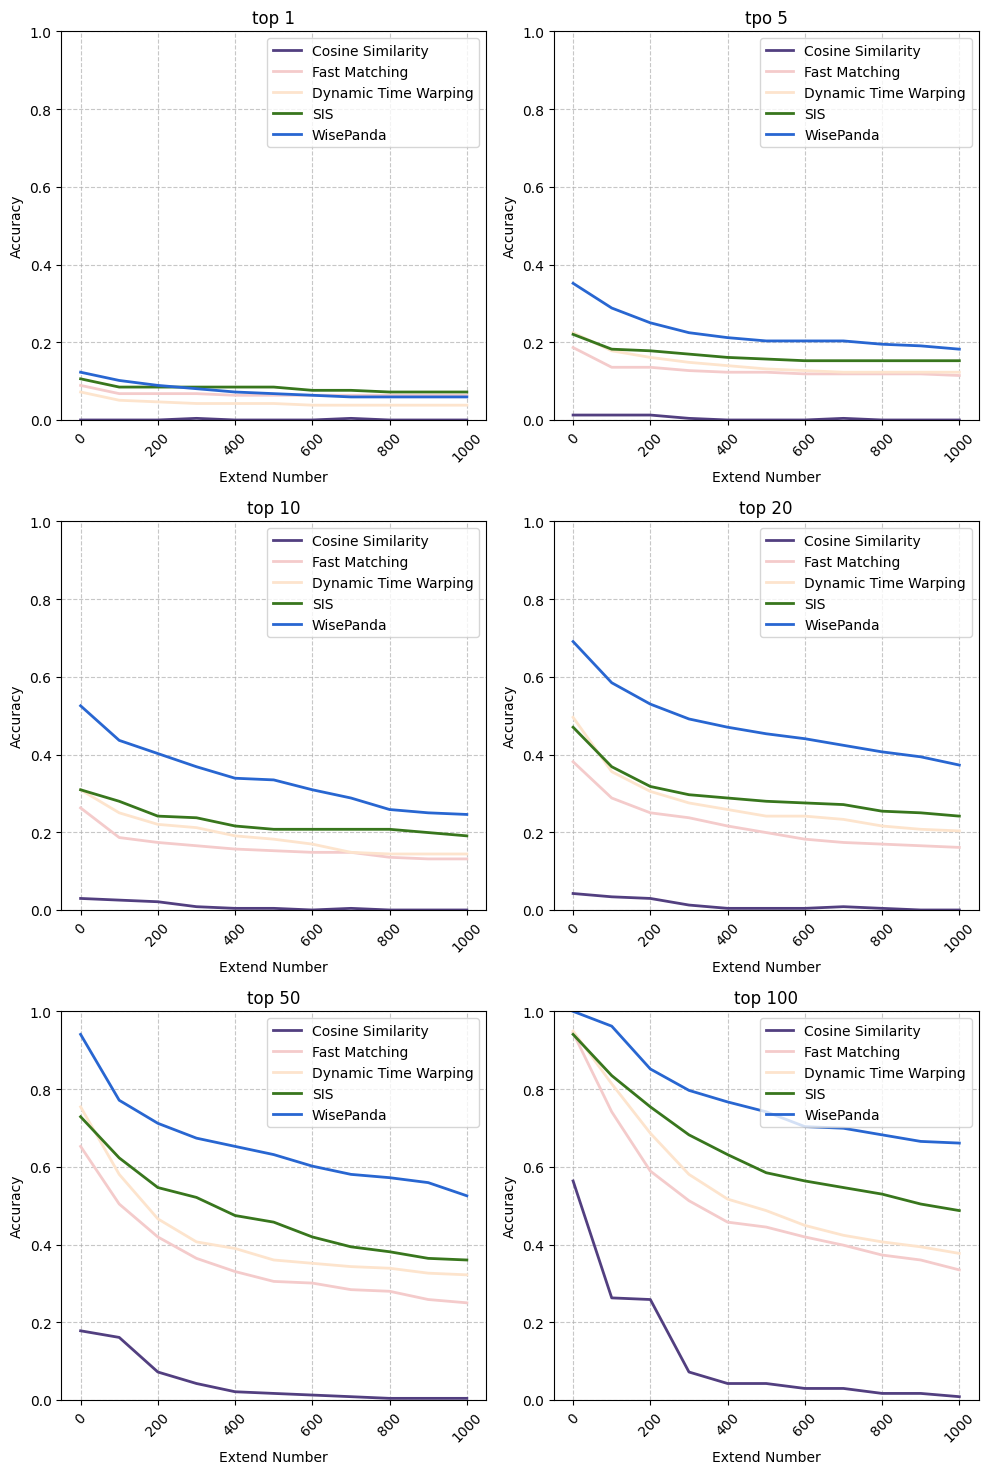

In [ ]:
# Create figure and subplots
fig, axes = plt.subplots(3, 2, figsize=(10, 15))
fig.suptitle('', fontsize=16)

# Flatten axes for easier iteration
axes = axes.flatten()

# Create x-axis values (0 to 1000 with step 100)
x_values = list(range(0, 1001, 100))

# Data pairs to plot
data_pairs = [
    ( wisepanda_k_list[0], cosine_similarity_k_list[0], fast_marching_k_list[0], dynamic_time_warping_k_list[0], scale_invariant_signatures_k_list[0], 'top 1'),
    ( wisepanda_k_list[1], cosine_similarity_k_list[1], fast_marching_k_list[1], dynamic_time_warping_k_list[1], scale_invariant_signatures_k_list[1], 'tpo 5'),
    ( wisepanda_k_list[2], cosine_similarity_k_list[2], fast_marching_k_list[2], dynamic_time_warping_k_list[2], scale_invariant_signatures_k_list[2], 'top 10'),
    ( wisepanda_k_list[3], cosine_similarity_k_list[3], fast_marching_k_list[3], dynamic_time_warping_k_list[3], scale_invariant_signatures_k_list[3], 'top 20'),
    ( wisepanda_k_list[4], cosine_similarity_k_list[4], fast_marching_k_list[4], dynamic_time_warping_k_list[4], scale_invariant_signatures_k_list[4], 'top 50'),
    ( wisepanda_k_list[5], cosine_similarity_k_list[5], fast_marching_k_list[5], dynamic_time_warping_k_list[5], scale_invariant_signatures_k_list[5], 'top 100')
]

# Plot each subplot
for idx, (wisepanda_data, cosine_data, fast_marching_data, dynamic_time_warping_data, scale_invariant_signatures_data, title) in enumerate(data_pairs):
    ax = axes[idx]
    
    # Plot both lines with custom colors
    ax.plot(x_values, cosine_data, color='#523F80', label='Cosine Similarity', marker='', linewidth=2, markersize=6)
    ax.plot(x_values, fast_marching_data, color='#F4CBCB', label='Fast Matching', marker='', linewidth=2, markersize=6)
    ax.plot(x_values, dynamic_time_warping_data, color='#FDE4CD', label='Dynamic Time Warping', marker='', linewidth=2, markersize=6)
    ax.plot(x_values, scale_invariant_signatures_data, color='#38761D', label='SIS', marker='', linewidth=2, markersize=6)
    ax.plot(x_values, wisepanda_data, color='#2866D1', label='WisePanda', marker='', linewidth=2, markersize=6)
   

    # Customize subplot
    ax.set_title(title)
    ax.set_xlabel('Extend Number')
    ax.set_ylabel('Accuracy')
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.legend()
    
    # Set y-axis limits from 0 to 1 (assuming these are accuracy values)
    ax.set_ylim(0, 1)
    
    # Add x-axis ticks every 200 units
    ax.set_xticks(np.arange(0, 1001, 200))
    ax.tick_params(axis='x', rotation=45)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()